#디렉토리 생성 

In [1]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from IPython.display import Image
from IPython.display import clear_output
import warnings
import os 
from glob import glob 
import pandas as pd 
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 
os.makedirs('./thumb/train/up')
os.makedirs('./thumb/train/down')
os.makedirs('./thumb/test/up')
os.makedirs('./thumb/test/down')

# 이미지 캡쳐 

## 코랩용 

In [2]:
def take_photo(file_path, quality=1.0):
  js = Javascript('''
    async function takePhoto([quality,file_path]) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      const train_up = document.createElement('button')
      const train_down = document.createElement('button');
      const test_up = document.createElement('button');
      const test_down = document.createElement('button');
      
      capture.textContent = 'Capture';
      train_up.textContent = 'Train/up';
      train_down.textContent = 'Train/Down';
      test_up.textContent = 'Test/Up';
      test_down.textContent = 'Test/Down';
      
      div.appendChild(capture);
      div.appendChild(train_up);
      div.appendChild(train_down);
      div.appendChild(test_up);
      div.appendChild(test_down);

      train_up.onclick = function(){
        file_path = './thumb/train/up'
      }

      train_down.onclick = function(){
        file_path = './thumb/train/down'
      }

      test_up.onclick = function(){
        file_path = './thumb/test/up'
      }

      test_down.onclick = function(){
        file_path = './thumb/test/down'
      }

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);



      // Wait for Capture to be clicked.
    
      await new Promise((resolve) => capture.onclick = resolve);
      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      
      return [canvas.toDataURL('image/jpeg', quality),file_path];
    }
    ''')
  display(js)
  data,file_path = eval_js('takePhoto({})'.format([quality,file_path]))
  binary = b64decode(data.split(',')[1])
  return binary,file_path

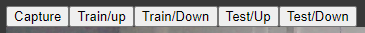

- 실행 시 위와 같은 버튼 들이 웹캠 상단에 나타 남 

- `Caputure` -> 웹캠의 이미지를 저장하는 버튼 
- `나머지넷` -> 이미지 저장 경로를 설정하는 버튼 

- 최초 기본 설정은 `train/up` 으로 설정되어 있으며 `Train/Down`을 클릭 후 `Cqpture`를 누를 시 `train/down` 경로로 저장 됨 
- while loop가 돌아가는 도중에는 클릭 한 경로로 계속해서 지정 됨
  ```
  예시 
    `Train/Down`한 번 누르면 계속해서 `Train/Down`으로 저장 됨 <-- While loop 종료될 때 까지 
  
     while loop 종료 후 다시 시작 시 초기 설정 경로인 `train/up`으로 저장 됨 
  ```


In [ ]:
quality = 1.0
file_path = './thumb/train/up' #<--- 초기 경로 
while(True):
  binary,file_path = take_photo(file_path,quality)
  
  try:
    max_value = max(pd.Series(glob(os.path.join(file_path,'*'))).apply(lambda x:x.split('/')[-1].replace('image','').replace('.jpg','')).map(int))
    file_name = file_path + f'/image{max_value+1}.jpg'
  except:
    max_value = 0 
    file_name = file_path + f'/image{max_value}.jpg' 

      
  with open(file_name,'wb') as f:
    f.write(binary)
  print(file_name)

<IPython.core.display.Javascript object>

./thumb/train/up/image0.jpg


<IPython.core.display.Javascript object>

./thumb/train/down/image0.jpg


<IPython.core.display.Javascript object>

./thumb/train/down/image1.jpg


<IPython.core.display.Javascript object>

./thumb/test/up/image0.jpg


<IPython.core.display.Javascript object>

./thumb/test/up/image1.jpg


<IPython.core.display.Javascript object>

TypeError: ignored

#로컬용 

In [ ]:
import tkinter
import cv2
import PIL.Image, PIL.ImageTk
import datetime
import os 

class App:
    def __init__(self, window, window_title, video_source=0):
        self.window = window
        self.window.title(window_title)
        self.video_source = video_source
        self.is_recording = False

        # open video source (by default this will try to open the computer webcam)
        self.vid = MyVideoCapture(self.video_source)

        # Create a canvas that can fit the above video source size
        self.canvas = tkinter.Canvas(window, width = self.vid.width, height = self.vid.height)
        self.canvas.pack()

        # Button that lets the user take a snapshot
        #n, ne, e, se, s, sw, w, nw, or center
        self.btn_snapshot = tkinter.Button(window, text="학습용-엄지위", width=20, height=5, command=self.record_train_up)
        self.btn_snapshot.pack(side='left', expand=True)
        self.btn_snapshot = tkinter.Button(window, text="학습용-엄지아래", width=20, height=5, command=self.record_train_down)
        self.btn_snapshot.pack(side='left', expand=True)
        self.btn_snapshot = tkinter.Button(window, text="시험용-엄지위", width=20, height=5, command=self.record_test_up)
        self.btn_snapshot.pack(side='left', expand=True)
        self.btn_snapshot = tkinter.Button(window, text="시험용-엄지아래", width=20, height=5, command=self.record_test_down)
        self.btn_snapshot.pack(side='right', expand=True)

        # After it is called once, the update method will be automatically called every delay milliseconds
        self.fps = self.vid.webcam.get(cv2.CAP_PROP_FPS)
        self.delay = round(1000.0/self.fps)
        self.update()

        self.window.mainloop()

    def record_train_up(self):
        input_path = './thumb/train/up/'
        file_name = 'train_up'
        file_ext = '.jpg'
        uniq=1
        output_path = '%s%s%s' %(input_path,file_name,file_ext)
        while os.path.exists(output_path):
            output_path='%s%s_%d%s' %(input_path,file_name,uniq,file_ext)
            uniq+=1
        cv2.imwrite(output_path,self.frame)
    
    def record_train_down(self):
        input_path = './thumb/train/down/'
        file_name = 'train_down'
        file_ext = '.jpg'
        uniq=1
        output_path = '%s%s%s' %(input_path,file_name,file_ext)
        while os.path.exists(output_path):
            output_path='%s%s_%d%s' %(input_path,file_name,uniq,file_ext)
            uniq+=1
        cv2.imwrite(output_path,self.frame)

    def record_test_up(self):
        input_path = './thumb/test/up/'
        file_name = 'test_up'
        file_ext = '.jpg'
        uniq=1
        output_path = '%s%s%s' %(input_path,file_name,file_ext)
        while os.path.exists(output_path):
            output_path='%s%s_%d%s' %(input_path,file_name,uniq,file_ext)
            uniq+=1
        cv2.imwrite(output_path,self.frame)

    def record_test_down(self):
        input_path = './thumb/test/down/'
        file_name = 'test_down'
        file_ext = '.jpg'
        uniq=1
        output_path = '%s%s%s' %(input_path,file_name,file_ext)
        while os.path.exists(output_path):
            output_path='%s%s_%d%s' %(input_path,file_name,uniq,file_ext)
            uniq+=1
        cv2.imwrite(output_path,self.frame)

    def update(self):
        # Get a frame from the video source
        ret,frame = self.vid.get_frame()
        self.frame = frame

        if ret:
            if self.is_recording:
                self.vid.video.write(frame)

            self.photo = PIL.ImageTk.PhotoImage(image = PIL.Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)))
            self.canvas.create_image(0, 0, image = self.photo, anchor = tkinter.NW)
        self.window.after(self.delay, self.update)

    # Release the video source when the object is destroyed
    def __del__(self):
        if self.is_recording:
           self.vid.video.release()

class MyVideoCapture:
    def __init__(self, video_source=0):
        # Open the video source
        self.webcam = cv2.VideoCapture(video_source)
        if not self.webcam.isOpened():
            raise ValueError("Unable to open video source", video_source)

        # Get video source width and height
        self.width = self.webcam.get(cv2.CAP_PROP_FRAME_WIDTH)
        self.height = self.webcam.get(cv2.CAP_PROP_FRAME_HEIGHT)
        #self.width = 1280
        #self.height = 720
        #self.webcam.set(cv2.CAP_PROP_FRAME_WIDTH, self.width)
        #self.webcam.set(cv2.CAP_PROP_FRAME_HEIGHT, self.height)

    def create_video(self, fps):
        file_name = str(datetime.datetime.now()) + '.mp4'
        # Define the codec and create VideoWriter object
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # opencv 3.0
        # Error: 'module' object has no attribute 'VideoWriter_fourcc'
        # fourcc=cv2.VideoWriter_fourcc('X', 'V', 'I', 'D')
        # jpeg,h263,'m', 'p', '4', 'v'
        self.video = cv2.VideoWriter(file_name, fourcc, fps/3.0, (self.width, self.height))

    def get_frame(self):
        if self.webcam.isOpened():
            font_color = (255, 255, 255)
            ret, frame = self.webcam.read()
            if ret:
                frame = cv2.flip(frame, 1)

                # describe the type of
                # font you want to display
                font = cv2.FONT_HERSHEY_SCRIPT_COMPLEX

                # Get date and time and
                # save it inside a variable
                dt = str(datetime.datetime.now())

                # put the dt variable over the
                # video frame
                # frame = cv2.putText(frame, dt,
                #                     (30, 60),    # position
                #                     font, 1, font_color, 4, cv2.LINE_AA)

                # Return a boolean success flag and the current frame converted to BGR
                return (ret, frame)
            else:
                return (ret, None)
        else:
            return (False, None)

     # Release the video source when the object is destroyed
    def __del__(self):
        if self.webcam.isOpened():
            self.webcam.release()

# Create a window and pass it to the Application object
App(tkinter.Tk(), "Tkinter and OpenCV")

# 이미지 저장 

In [ ]:
!cp thumb ./drive/Mydrive

Mounted at /content/drive
